# Custom Simulations

In [ ]:
#@title Imports and Definitions
#!pip install jax-md
!pip install -q git+https://www.github.com/google/jax-md

import numpy as onp

import jax.numpy as jnp
from jax.config import config
config.update('jax_enable_x64', True)

from jax import random
from jax import jit, lax, grad, vmap, hessian
import jax.scipy as jsp

from jax_md import space, energy, smap, simulate, minimize, util, elasticity, quantity, partition
from jax_md.colab_tools import renderer

f32 = jnp.float32
f64 = jnp.float64

from functools import partial

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])

def prepare_trajectory(trajectory, expand_axis = None, color_scheme = 'Set1'):
  """(t,n,N,d) -> (t,n*N,d) plus colors
  """
  if expand_axis is not None:
    trajectory = jnp.expand_dims(trajectory, expand_axis)
  
  s = trajectory.shape
  assert len(s) == 4
  new_trajectory = trajectory.reshape((s[0], s[1]*s[2], s[3]))

  cm = plt.get_cmap(color_scheme)
  cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=s[1])
  scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
  colors = scalarMap.to_rgba(jnp.arange(s[1]*s[2]) // s[2])

  return new_trajectory, colors[:,:3]

def show_trajectory(trajectory, 
                    expand_axis = None, 
                    color_scheme = 'Set1',
                    diameters = 1):
  traj, colors = prepare_trajectory(trajectory, expand_axis, color_scheme)

  renderer.render(box_size,
                  {'particles': renderer.Disk(traj, diameters, color=colors)},
                  resolution=(512, 512))

## Time-dependent parameters

Define a system



In [ ]:
N = 1000
dimension = 2

# Define boundary conditions
box_size = quantity.box_size_at_number_density(N, 0.7, 2)
displacement, shift = space.periodic(box_size) 

# Define initial positions
key = random.PRNGKey(0)
R_init = box_size * random.uniform(key, (N, dimension), dtype=jnp.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = jnp.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = jnp.where(jnp.arange(N) < N_2, 0, 1)
diameters = sigma.diagonal()[species]

# Define energy and neighbor functions
neighbor_fn, energy_fn = energy.soft_sphere_neighbor_list(
    displacement,
    box_size,
    species,
    sigma,
    dr_threshold=0.2,
    format=partition.Sparse)

# Allocate the neighbor list
nbrs_init = neighbor_fn.allocate(R_init)

define and run a basic NVT simulation

In [ ]:
dt = 5e-3
kT = 0.01 

steps = 10000
write_every = 100

init, apply = simulate.nvt_nose_hoover(energy_fn, shift, dt, kT)
state = init(key, R_init, neighbor=nbrs_init)

def step_fn(i, state_nbrs_log):
  state, nbrs, log = state_nbrs_log
  nbrs = nbrs.update(state.position)

  # Log information about the simulation.
  T = quantity.temperature(momentum=state.momentum)
  log['kT'] = log['kT'].at[i].set(T)
  H = simulate.nvt_nose_hoover_invariant(energy_fn, state, kT, neighbor=nbrs)
  log['H'] = log['H'].at[i].set(H)
  # Record positions every `write_every` steps.
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: \
                             p.at[i // write_every].set(state.position),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, kT=kT, neighbor=nbrs)
  
  return state, nbrs, log

log = {
    'kT': jnp.zeros((steps,)),
    'H': jnp.zeros((steps,)),
    'position': jnp.zeros((steps // write_every,) + R_init.shape) 
}

state, nbrs, log = lax.fori_loop(0, steps, step_fn, (state, nbrs_init, log))

In [ ]:
show_trajectory(log['position'], expand_axis=1, diameters=diameters)

In [ ]:
t = jnp.arange(0, steps) * dt
plt.plot(t, log['kT'], linewidth=3)
plt.plot(t, kT+0*t, linewidth=3)
format_plot('$t$', '$T$')
finalize_plot()

Now redo with a time varying temperature

In [ ]:
dt = 5e-3
kT = lambda t: jnp.where(t < 25, 0.1, 0.01)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

steps = 10000
write_every = 100

init, apply = simulate.nvt_nose_hoover(energy_fn, shift, dt, kT(0))
#............................................................^^^^^.
state = init(key, R_init, neighbor=nbrs_init)

def step_fn(i, state_nbrs_log):
  state, nbrs, log = state_nbrs_log
  nbrs = nbrs.update(state.position)

  t = i * dt
  #^^^^^^^^^

  # Log information about the simulation.
  T = quantity.temperature(momentum=state.momentum)
  log['kT'] = log['kT'].at[i].set(T)
  H = simulate.nvt_nose_hoover_invariant(energy_fn, state, kT(t), neighbor=nbrs)
  #........................................................^^^^^................
  log['H'] = log['H'].at[i].set(H)
  # Record positions every `write_every` steps.
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: \
                             p.at[i // write_every].set(state.position),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, kT=kT(t), neighbor=nbrs)
  #....................^^^^^^^^................
  
  return state, nbrs, log

log = {
    'kT': jnp.zeros((steps,)),
    'H': jnp.zeros((steps,)),
    'position': jnp.zeros((steps // write_every,) + R_init.shape) 
}

state, nbrs, log = lax.fori_loop(0, steps, step_fn, (state, nbrs_init, log))

In [ ]:
show_trajectory(log['position'], expand_axis=1, diameters=diameters)

In [ ]:
t = jnp.arange(0, steps) * dt
plt.plot(t, log['kT'], linewidth=3)
plt.plot(t, kT(t), linewidth=3)
format_plot('$t$', '$T$')
finalize_plot()

**Lots of parameters can be time varying!**


## Spatially verying temperatures

Consider a systems with an inhomogeneous temperature. The temperature will vary in the y direction as given by `kT_fn`:

In [ ]:
kT_edge = 0.05
scale_factor = 6
kT_fn = lambda R: kT_edge * (1 + scale_factor * (0.5 - jnp.abs(R[:, -1] / box_size - 0.5)))

xs = jnp.linspace(0, box_size, 100)
plt.plot(xs, kT_fn(jnp.broadcast_to(xs[:, None], (len(xs), 3))), 'k--')
format_plot('$y$', '$kT(y)$')
finalize_plot()

In practice, this function takes a set of positions and returns the temperature for each. 

In [ ]:
R = log['position'][-1]
kT = kT_fn(R)
#^^^^^^^^^^^^

cm = plt.get_cmap('cool')
cNorm = matplotlib.colors.Normalize(vmin=jnp.min(kT), vmax=jnp.max(kT))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
colors = scalarMap.to_rgba(kT)[:,:3]
renderer.render(box_size,
                  {'particles': renderer.Disk(R, diameters, color=colors)},
                  resolution=(512, 512))

Now, we will edit `simulate.nvt_nose_hoover` to create a custom simulation environment where each particle has its own temperature.

The strategy will be to use `vmap` to create and use a seperate Hose-Hoover chain for each particle.

In [ ]:
from typing import Callable, Optional

ShiftFn = space.ShiftFn
Array = util.Array
Simulator = simulate.Simulator
 
def nvt_nose_hoover(energy_or_force_fn: Callable[..., Array],
                    shift_fn: ShiftFn,
                    dt: float,
                    kT_fn: float,
                    chain_length: int=5,
                    chain_steps: int=2,
                    sy_steps: int=3,
                    tau: Optional[float]=None,
                    **sim_kwargs) -> Simulator:
  force_fn = quantity.canonicalize_force(energy_or_force_fn)
  dt = f32(dt)
  dt_2 = f32(dt / 2)
  if tau is None:
    tau = dt * 100
  tau = jnp.float32(tau)

  thermostat = simulate.nose_hoover_chain(dt, chain_length, chain_steps, sy_steps, tau)

  @jit
  def init_fn(key, R, mass=f32(1.0), **kwargs):
    # 1) Compute per-particle temperature.
    kT = kT_fn(R)
    #^^^^^^^^^^^

    state = simulate.NVTNoseHooverState(R, None, force_fn(R, **kwargs), mass, None)
    state = simulate.canonicalize_mass(state)
    state = simulate.initialize_momenta(state, key, 1e-2)

    # 2) Compute per-particle kinetic energy.
    KE = vmap(simulate.kinetic_energy)(state)
    #....^^^^................................

    # 3) Create one Nose-Hoover chain per-particle, with d degrees of freedom
    return state.set(chain=vmap(thermostat.initialize, (None, 0, 0))(R.shape[-1], KE, kT))
    #......................^^^^......................................^^^^^^^^^^^^^^^^^^^..

  @jit
  def apply_fn(state, **kwargs):
    # 1) Compute per-particle temperatures.
    kT = kT_fn(state.position)
    #^^^^^^^^^^^^^^^^^^^^^^^^^

    chain = state.chain

    # 2) Update all of the chain masses.
    chain = vmap(thermostat.update_mass)(chain, kT)
    #.......^^^^...................................

    # 3) Do the first half-step update for all of the chains.
    p, chain = vmap(thermostat.half_step)(state.momentum, chain, kT)
    #..........^^^^.................................................

    state = state.set(momentum=p)
    state = simulate.velocity_verlet(force_fn, shift_fn, dt, state, **kwargs)

    # 4) Compute kinetic energy per particle.
    chain = chain.set(kinetic_energy=vmap(simulate.kinetic_energy)(state))
    #................................^^^^.................................
    
    # 5) Do the second half-step update for all of the chains.
    p, chain = vmap(thermostat.half_step)(state.momentum, chain, kT)
    #..........^^^^.................................................

    state = state.set(momentum=p, chain=chain)

    return state
  return init_fn, apply_fn

Define a new bigger system

In [ ]:
N = 10_000
dimension = 2

# Define boundary conditions
box_size = quantity.box_size_at_number_density(N, 0.7, 2)
displacement, shift = space.periodic(box_size) 

# Define initial positions
key = random.PRNGKey(0)
key, split = random.split(key)
R_init = box_size * random.uniform(split, (N, dimension), dtype=jnp.float64)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = jnp.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = jnp.where(jnp.arange(N) < N_2, 0, 1)
diameters = sigma.diagonal()[species]

# Define energy and neighbor functions
neighbor_fn, energy_fn = energy.soft_sphere_neighbor_list(
    displacement,
    box_size,
    species,
    sigma,
    dr_threshold=0.2,
    format=partition.Sparse)

# Allocate the neighbor list
nbrs_init = neighbor_fn.allocate(R_init)

Run our custom simulation

In [ ]:
dt = 5e-3

steps = 10000
write_every = 100

init, apply = nvt_nose_hoover(energy_fn, shift, dt, kT_fn)
#.............^^^^^^^^^^^^^^^.......................^^^^^

state = init(key, R_init, mass=jnp.ones((N,)), neighbor=nbrs_init)

def step_fn(i, state_nbrs_log):
  state, nbrs, log = state_nbrs_log
  nbrs = nbrs.update(state.position)

  # Log information about the simulation.
  # Record positions every `write_every` steps.
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: \
                             p.at[i // write_every].set(state.position),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, neighbor=nbrs)
  
  return state, nbrs, log

log = {
    'position': jnp.zeros((steps // write_every,) + R_init.shape, dtype=R_init.dtype) 
}

state, nbrs, log = lax.fori_loop(0, steps, step_fn, (state, nbrs_init, log))

Visualize the trajectory

In [ ]:
# Don't show the full trajectory (slow and not very informative)
#show_trajectory(log['position'], diameters=diameters)

# Instead, show the trajectory of 30 random particles
show_trajectory(log['position'][:,:30], expand_axis=1, diameters=diameters[:30])

Visualize the trajectory as a still image

In [ ]:
show_trajectory(log['position'][:,:30], expand_axis=0, diameters=diameters, color_scheme = 'jet')

Test by measuring the temperature as a function of $y$.

In [ ]:
from jax_md import partition
from jax import vmap

cell_size = 2
cell_list = partition.cell_list(box_size, cell_size)

cells = cell_list.allocate(state.position)

def temperature(momentum, mask):
  # mask = 1 if particle is in cell
  dof = dimension * jnp.sum(mask)
  return jnp.sum(mask * momentum**2) / (dof + 1e-7)

def z_temperature_2d(state):
  cl = cells.update(state.position, momentum=state.momentum)
  kT_fn = vmap(vmap(temperature))
  voxel_kT = kT_fn(cl.kwarg_buffers['momentum'], cl.id_buffer < N)
  return jnp.sum(voxel_kT, axis=1) / jnp.sum(voxel_kT > 0., axis=1)

xs = jnp.arange(0, box_size, cell_size)[:-1]

plt.plot(xs, z_temperature_2d(state), 'ko')
plt.plot(xs, kT_fn(jnp.broadcast_to(xs[:, None], (len(xs), 3))), 'k--')
plt.xlim([0, xs[-1]])
format_plot('$y$', '$kT_i$')
finalize_plot()

## Coupled Systems

In [ ]:
#@title Hidden Definitions

# Run a brownian dynamics simulation and save periodic snapshots
def run_brownian(
    energy_fn,
    R_init,
    shift,
    key,
    num_total_steps,
    record_every,
    dt,
    measure_fn=lambda R: R,
    **kwargs
  ):
    # define the simulation
    init, apply = simulate.brownian(energy_fn, shift, dt, **kwargs)
    apply = jit(apply)

    @jit
    def apply_single_step(state, t):
        return apply(state), 0

    @jit
    def apply_many_steps(state, t_list):
        state, _ = lax.scan(apply_single_step, state, t_list)
        return state, measure_fn(state.position)

    # initialize the system
    key, split = random.split(key)
    initial_state = init(split, R_init)

    # run the simulation
    final_state, data = lax.scan(
        apply_many_steps,
        initial_state,
        jnp.arange(num_total_steps).reshape(
            num_total_steps // record_every, record_every
        ),
    )

    # return the trajectory
    return data

def interpolate_positions(R1, R2, num_images, displacement, shift):
  """ Create images that span between R1 and R2

  Args:
    R1: array of shape (N,d) 
    R2: array of shape (N,d) 
    num_images: int indicating number of total images to be returned
    displacement: jax_md displacement function
    shift: jax_md shift function

  Return: array of shape (num_images, N, d) 
  """
  system_displacement = vmap(displacement, in_axes=(0,0))
  dr = system_displacement(R2, R1)
  
  #linear interpolation 
  return jnp.array([ shift(R1, i * dr) for i in jnp.linspace(0, 1, num_images)])

R1 = jnp.array([[0,0],
                [1,0],
                [0.5,jnp.sqrt(3)/2],
                [1.5,jnp.sqrt(3)/2]],
                dtype=jnp.float64)
R2 = jnp.array([[0,0],
                [1,0],
                [-0.5,jnp.sqrt(3)/2],
                [0.5,jnp.sqrt(3)/2]],
                dtype=jnp.float64)

R1 = R1 - jnp.mean(R1, axis=0)
R2 = R2 - jnp.mean(R2, axis=0)

theta = -jnp.pi/6
ct = jnp.cos(theta)
st = jnp.sin(theta)
rot = jnp.array([[ct, -st], [st, ct]])
R2 = vmap(jnp.matmul, in_axes=(None,0))(rot,R2)

R1 = R1 + 5
R2 = R2 + 5

We will consider a "harmonic morse" potential

In [ ]:
def harmonic_morse(dr, epsilon=5.0, alpha=5.0, sigma=1.0, k=50.0, **kwargs):
  U = jnp.where(dr < sigma, 
               0.5 * k * (dr - sigma)**2 - epsilon,
               energy.morse(dr, sigma, epsilon, alpha, **kwargs)
               )
  return jnp.array(U, dtype=dr.dtype)


epsilon = 5
alpha = 30
sigma = 1
k = alpha**2 * (2 * epsilon)

x=jnp.linspace(0.95,1.25,100)
y=harmonic_morse(x, epsilon, alpha, sigma, k)
y2 = energy.morse(x, epsilon = epsilon, alpha = alpha, sigma = sigma)
plt.plot(x,y, label='harmonic morse')
plt.plot(x,y2,label='morse')
plt.ylim(-7,20)
plt.legend()
format_plot('$r$','$V(r)$')
finalize_plot()

Use `smap.pair` to convert this into an energy function

In [ ]:
def hmorse_pair(displacement_or_metric,
               species = None,
               sigma = 1.0,
               epsilon = 1.0,
               alpha = 5.0,
               k=50.0):
  return smap.pair(
    harmonic_morse,
    space.canonicalize_displacement_or_metric(displacement_or_metric),
    ignore_unused_parameters = True,
    species = species,
    sigma = sigma,
    epsilon = epsilon,
    alpha = alpha,
    k = k,
    reduce_axis = None)
  
box_size = 10
displacement, shift = space.periodic(box_size)

energy_fn = hmorse_pair(displacement, k = k, epsilon = epsilon, alpha=alpha, sigma = sigma)

Consider 4 particles with the following positions

In [ ]:
show_trajectory(R1, expand_axis=(0,1))

Run a short Brownian Dynamics simulation, which is given by the overdamped Langevin equation:
\begin{equation}
\gamma {\dot  {R}}= -\nabla U(R) +{\sqrt  {2\gamma k_{B}T}}\; \Xi(t)
\end{equation}
where the noise $\Xi(t)$ simulates collisions of the particles with water molecules. The function `run_brownian` (defined above) runs the JAX-MD implementation of Brownian dynamics and returns the trajectory

In [ ]:
trajectory = run_brownian(energy_fn, R1, shift, random.PRNGKey(0), 100000, 100, dt = 0.00002, kT = 0.03)
show_trajectory(trajectory, expand_axis=1)

We can use `vmap` to run many simulations simultaneously

In [ ]:
temp_fn = lambda key: run_brownian(energy_fn, R1, shift, key, 100000, 100, dt = 0.00002, kT = 0.03)
number_of_systems = 4
trajectory = vmap(temp_fn)(random.split(random.PRNGKey(0),number_of_systems))
show_trajectory(jnp.einsum('ijkl->jikl',trajectory))

JAX-MD simulations are agnostic to the shape of your data, as long as your energy and shift functions know how to interpret it. 

Normally: `R.shape == (N_particles, dimension)`

However, we can use `R.shape == (N_systems, N_particles, dimension)` to run run multiple (independent) simulations at the same time, instead of using `vmap`.

In [ ]:
map_shift = vmap(shift)

map_energy_fn = vmap(energy_fn)
def total_energy_fn(Rall, **kwargs):
  return jnp.sum(map_energy_fn(Rall))

R_init = jnp.array([R1]*number_of_systems) #shape == (N_systems,N,d)
trajectory = run_brownian(total_energy_fn, R_init, map_shift, random.PRNGKey(0), 100000, 100, dt = 0.00002, kT = 0.03)
show_trajectory(trajectory)

Why do this?

The total energy does **not** have to be 
$$ E_\mathrm{total} = \sum_{i \in \mathrm{systems}} E(R_i)$$

Instead, we can introduce a coupling term so that the systems are no longer independent:
$$ E_\mathrm{total} = \sum_{i \in \mathrm{systems}} E(R_i) + E_\mathrm{coupling}(\{ R_i \})$$

We will place high-dimensional springs between neighboring systems...

In [ ]:
mapped_displacement = vmap(vmap(
  displacement, in_axes = (0,0)), in_axes = (0,0))

def setup_total_energy(k_spring):
  def coupling_energy_fn(Rall):
    """ Calculate the coupling energy that couples neighboring images

    Args:
      R: array of shape (num_images, N, d)

    Returns: the total coupling energy
    """
    return k_spring * jnp.sum( mapped_displacement(Rall[:-1], Rall[1:]) ** 2)
      
  def total_energy_fn(Rall, **kwargs):
    sum_true_energy = jnp.sum(map_energy_fn(Rall))
    coupling_energy = coupling_energy_fn(Rall)
    return sum_true_energy + coupling_energy
  
  return total_energy_fn

total_energy_fn = setup_total_energy(0.1)

number_of_systems = 8
R_init = jnp.array([R1]*number_of_systems) #shape == (N_systems,N,d)
trajectory = run_brownian(total_energy_fn, R_init, map_shift, random.PRNGKey(0), 200000, 200, dt = 0.00002, kT = 0.03)
show_trajectory(trajectory)

Now fix the end systems and add an offset

In [ ]:
def modified_map_shift(R, dR, **unused_kwargs):
  """Never move the first and last systems
  """
  dR = dR.at[0].set(jnp.zeros_like(dR[0]))
  dR = dR.at[-1].set(jnp.zeros_like(dR[-1]))
  return map_shift(R, dR)

offset = 2
R_init_all = interpolate_positions(R1 + offset, 
                                   R1 - offset, 
                                   number_of_systems, 
                                   displacement, 
                                   shift)

trajectory = run_brownian(total_energy_fn, R_init_all, modified_map_shift, random.PRNGKey(0), 200000, 200, dt = 0.00002, kT = 0.03)
show_trajectory(trajectory)

So far, we have always started with the same state, and the temperature is low enough that the system never leaves this structure.

Now, consider a second state:

In [ ]:
show_trajectory(jnp.array([R2+offset, R1-offset]), expand_axis=0)

These states are *not* rotations of each other:

In [ ]:
show_trajectory(jnp.einsum('jkl->kjl',jnp.array([R2+offset, R1-offset,])), expand_axis=0)

Now set one of the endpoints to be the second system

In [ ]:
offset = 2
R_init_all = interpolate_positions(R2 + offset, 
                                   R1 - offset, 
                                   number_of_systems, 
                                   displacement, 
                                   shift)

# Change k up to 10
total_energy_fn = setup_total_energy(10.0)
trajectory = run_brownian(total_energy_fn, R_init_all, modified_map_shift, random.PRNGKey(0), 200000, 200, dt = 0.00002, kT = 0.03)
show_trajectory(trajectory)

One of the systems is "intermediate"

In [ ]:
show_trajectory(trajectory[:,4], expand_axis=1)

Now:
*   set the temperature to zero 
*   make the coupling very strong
*   remove the offset
*   include 50 images

In [ ]:
offset = 0
R_init_all = interpolate_positions(R2 + offset, R1 - offset, 50, displacement, shift)

total_energy_fn = setup_total_energy(100.0)
trajectory = run_brownian(total_energy_fn, R_init_all, modified_map_shift, random.PRNGKey(0), 20000, 200, dt = 0.000002, kT = 0.)

In [ ]:
plt.plot(vmap(energy_fn)(trajectory[-1]), marker='o')
plt.title('energy of last state')
format_plot('system number', 'energy')
finalize_plot()

In [ ]:
show_trajectory(trajectory[-1], expand_axis=1)

### Doubly Nudged Elastic Band Method

Image credit: https://uspex-team.org/online_utilities/uspex_manual/vcneb.html

Doubly Nudged Elastic Band method

---



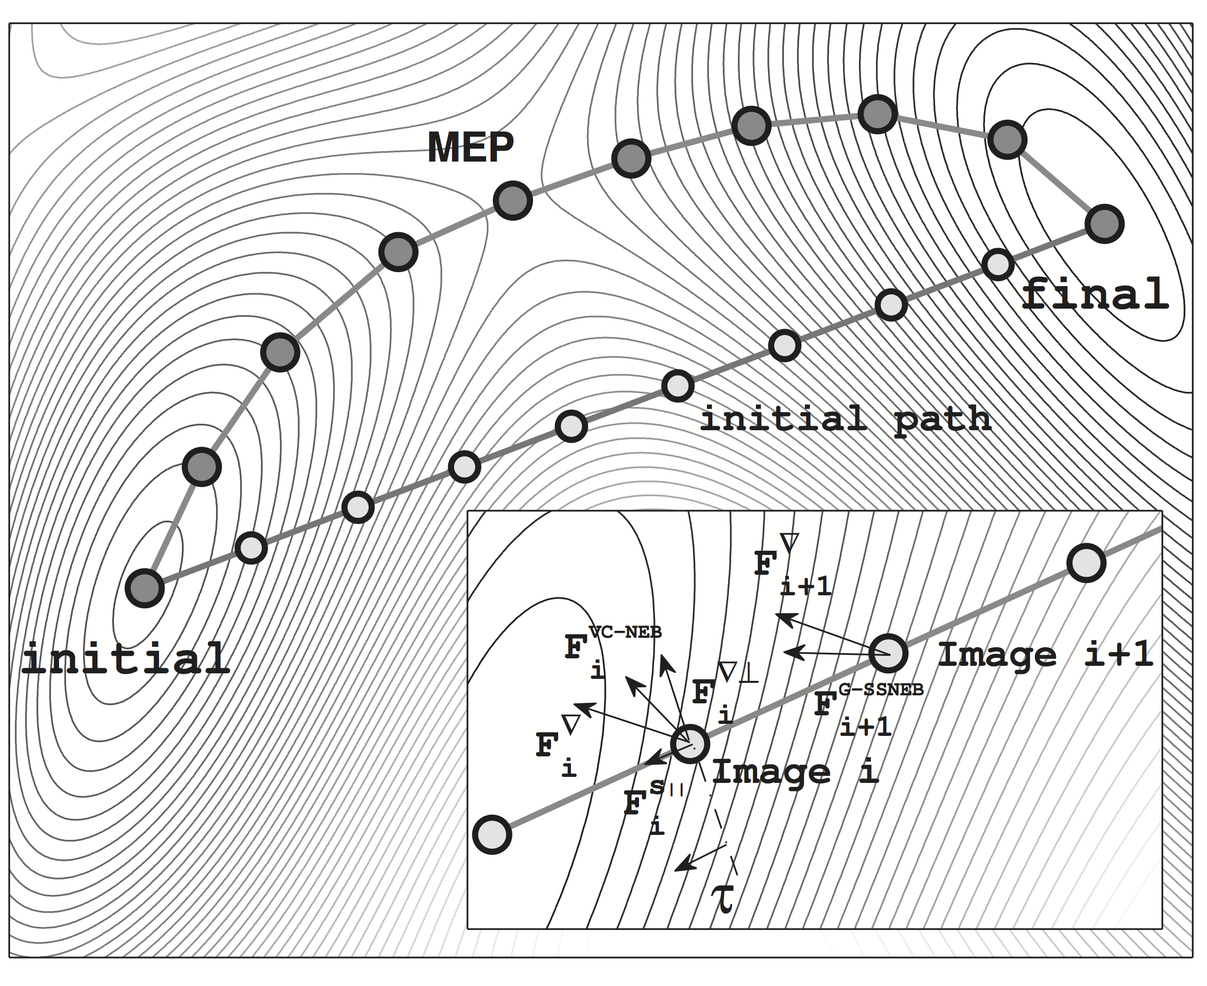

In [ ]:
#@title DNEB code
def setup_DNEB_force(true_energy_fn, spring_energy_fn, displacement):
  """ Defines Doubly Nudged Elastic Band calculations

  Args:
    true_energy_fn:  A function that takes an (N,d) array of positions and 
      returns an energy. 
    spring_energy_fn: A function that takes an (m,N,d) array of positions and 
      returns an energy (corresponding to the springs that couple the m systems)
    displacement: jax_md displacement function

  """

  multi_system_displacement = vmap(vmap(
    displacement, in_axes=(0,0)), in_axes=(0,0))

  true_energy_full_fn = vmap(true_energy_fn)
  true_gradient_full_fn = vmap(grad(true_energy_fn))
  spring_gradient_fn = grad(spring_energy_fn)

  true_energy_full_fn = jit(true_energy_full_fn)
  true_gradient_full_fn = jit(true_gradient_full_fn)
  spring_gradient_fn = jit(spring_gradient_fn)

  def calculate_tau_hat(R):
    energies = true_energy_full_fn(R)
    dE = energies[1:] - energies[:-1]  #E(i+1) - E(i) for all i
    #energy differences of neighbors i-1, i, and i+1
    dEr = dE[1:]  #E(i+1) - E(i)
    dEl = dE[:-1]  #E(i) - E(i-1)
    #maximum/minimum values
    dEmax = jnp.maximum(jnp.abs(dEr), jnp.abs(dEl))
    dEmin = jnp.minimum(jnp.abs(dEr), jnp.abs(dEl))

    #case separation: write down and normalize all 4 different tangent vectors (all have same length)
    #tau0 & tau1 are cases in which eq. (4) from DNEB paper can be applied
    #tau0 = R[2:] - R[1:-1]  #R(i+1)-R(i)
    tau0 = multi_system_displacement(R[1:-1], R[2:])
    #tau1 = R[1:-1] - R[:-2]  #R(i)-R(i-1)
    tau1 = multi_system_displacement(R[:-2], R[1:-1])
    #tau2 & tau3 are cases in which eq. (4) cannot be applied, i.e., image i is at a minimum/maximum
    #compute weighted average of the vectors to the two neighboring images, eqs. (10)+(11) from G. Henkelman and H. Jónsson, J. Chem. Phys. 113, 9978 (2000)
    tau2 = vmap(jnp.dot)(tau0, dEmax) + vmap(jnp.dot)(tau1, dEmin)
    tau3 = vmap(jnp.dot)(tau0, dEmin) + vmap(jnp.dot)(tau1, dEmax)
    #normalization
    tau0 = tau0 / jnp.linalg.norm(tau0, axis=(1, 2), keepdims=True)
    tau1 = tau1 / jnp.linalg.norm(tau1, axis=(1, 2), keepdims=True)
    tau2 = tau2 / jnp.linalg.norm(tau2, axis=(1, 2), keepdims=True)
    tau3 = tau3 / jnp.linalg.norm(tau3, axis=(1, 2), keepdims=True)

    #4 cases
    v0 = jnp.array(
        jnp.logical_and(dEl > 0, dEr > 0), dtype=jnp.int32)  #E(i+1)>E(i)>E(i-1)
    v1 = jnp.array(
        jnp.logical_and(dEl < 0, dEr < 0), dtype=jnp.int32)  #E(i+1)<E(i)<E(i-1)
    v2 = jnp.array(
        jnp.logical_and((v0 + v1) != 1, (dEr + dEl) > 0),
        dtype=jnp.int32)  #min/max and E(i+1)>E(i-1)
    v3 = jnp.array(
        jnp.logical_and((v0 + v1) != 1, (dEr + dEl) < 0),
        dtype=jnp.int32)  #min/max and E(i+1)<E(i-1)
    v = 0 * v0 + 1 * v1 + 2 * v2 + 3 * v3  #index array, tells for each element, which of the taus to choose

    choices = jnp.array([tau0, tau1, tau2, tau3])  #set of arrays to choose from
    tau = jnp.array(
        vmap(lambda choices, v: choices[v], in_axes=(1, 0))(choices, v))
    return tau

  #non-normalized projection of a onto b.
  # for this to be a proper projection, b should already be normalized
  def projection(a, b):
    return jnp.tensordot(a, b) * b

  vmap_projection = vmap(projection)

  def total_force(Rs):
    g = true_gradient_full_fn(Rs)[1:-1]
    gtilde = spring_gradient_fn(Rs)[1:-1]
    tauhat = calculate_tau_hat(Rs)

    #split the true potential up into parallel and perpendicular parts
    g_parallel = vmap_projection(g, tauhat)
    g_perp = g - g_parallel

    #split the spring potential up into parallel and perpendicular parts
    gtilde_parallel = vmap_projection(gtilde, tauhat)
    gtilde_perp = gtilde - gtilde_parallel

    #calculate gtilde_star via eq. (13). this is the "second nudge"
    g_perp_hat = g_perp / jnp.linalg.norm(g_perp, axis=(1, 2), keepdims=True)
    gtilde_star = gtilde_perp - vmap_projection(gtilde_perp, g_perp_hat)

    #get the total gradient via eq. (12) with some parts (g_parallel and gtilde_perp) projected out
    gtotal = g_perp + gtilde_parallel + gtilde_star

    #put zeros at the beginning and end, and multiply by -1 to make the gradient a force
    temp = jnp.zeros((1,) + tauhat[0].shape, dtype=Rs.dtype)
    return -jnp.concatenate((temp, gtotal, temp))

  return total_force

def setup_DNEB_minimization(true_energy_fn,
                            spring_energy_fn,
                            displacement_fn,
                            shift_fn,
                            dt_start=0.0001,
                            dt_max=0.0004,
                            num_images=100,
                            max_grad_thresh=1e-12,
                            max_num_steps=100000,
                            return_dneb_force_fn=False):
  """ Define a function to minimize a DNEB
  """

  true_energy_full_fn = vmap(true_energy_fn)

  total_force = setup_DNEB_force(true_energy_fn, spring_energy_fn, displacement_fn)
  total_force = jit(total_force)

  fire_init, fire_apply = minimize.fire_descent(
      total_force, vmap(shift_fn), dt_start=dt_start, dt_max=dt_max)
  fire_apply = jit(fire_apply)

  @jit
  def get_maxgrad(state):
    return jnp.amax(jnp.abs(state.force))

  @jit
  def cond_fn(val):
    state, i = val
    return jnp.logical_and(
        get_maxgrad(state) > max_grad_thresh, i < max_num_steps)

  @jit
  def body_fn(val):
    state, i = val
    return fire_apply(state), i + 1

  def minimize_DNEB(R_input, verbose=False):
    """ minimize a DNEB

    Args: 
      R_input: list or array of shape (n, N, d)
        If n==2, these are taken to be DNEB endpoints and image states are 
          generated using linear interpolation
        If n>2, these are taken to be the full DNEB path

      Return: (Rfinal, Efinal)
        Rfinal: an array of shape (num_images, N, d) or (n, N, d) 
          giving the positions of all images as found by the DNEB
        Efinal: array of shape (num_images,) or (n,) giving the true 
          energy of each image
    """
    R_input = jnp.array(R_input)
    if R_input.shape[0] > 2:
      Rinit = R_input
    elif R_input.shape[0] == 2:
      R1 = R_input[0]
      R2 = R_input[1]
      Rinit = interpolate_positions(R1, R2, num_images, displacement_fn, shift_fn)
    else:
      assert False

    state = fire_init(Rinit)
    state, num_iterations = lax.while_loop(cond_fn, body_fn, (state, 0))

    if verbose:
      print('finished minimizing dneb. max_grad = {}, num_iter = {}'.format(jnp.amax(jnp.abs(state.force)), num_iterations))

    Rfinal = state.position
    Efinal = true_energy_full_fn(Rfinal)

    return Rfinal, Efinal 

  if return_dneb_force_fn:
    return minimize_DNEB, total_force
  else:
    return minimize_DNEB

def plot_dneb(dneb_results):
  plt.plot(dneb_results[1], marker='o')
  format_plot('DNEB image','energy [$k_\mathrm{B}T$]')
  plt.title('energy along DNEB path')
  finalize_plot()

In [ ]:
def spring_energy_fn(Rall):
  """ Calculate the coupling energy that couples neighboring images
  """
  k_spring = 0.2
  return k_spring * jnp.sum( mapped_displacement(Rall[:-1], Rall[1:]) ** 2)


minimize_dneb = setup_DNEB_minimization(energy_fn, spring_energy_fn, displacement, shift, dt_start = 0.001, dt_max = 0.005, num_images = 50, max_num_steps = 50000)
dneb_results = minimize_dneb(R_init_all, verbose=True)

In [ ]:
plot_dneb(dneb_results)

In [ ]:
show_trajectory(dneb_results[0], expand_axis=1)